# Graph Representation for A-MCTS

This notebook explores the graph representation used in the A-MCTS algorithm, focusing on:
1. Attributed Dynamic Graphs (ADGs)
2. Temporal Paths

These data structures are fundamental to the A-MCTS algorithm as they represent the problem space and solutions.

In [1]:
# Import required modules
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from typing import Dict, Tuple, List

# Add the project root to sys.path
sys.path.append(os.path.abspath('..'))

# Import project modules
from src.graph import AttributedDynamicGraph, TemporalPath

## Attributed Dynamic Graphs (ADGs)

An Attributed Dynamic Graph (ADG) is a graph where:
- Edges have temporal information (departure and arrival times)
- Edges have multiple attributes (e.g., cost, time, reliability)

This is different from traditional graphs where edges are always available and typically have a single weight attribute.

In [4]:
# Create a simple ADG
def create_example_graph() -> AttributedDynamicGraph:
    """Create an example attributed dynamic graph for demonstration."""
    graph = AttributedDynamicGraph()
    
    # Add edges with attributes (cost and time)
    # Format: (source, dest, length, dep_time, arr_time, attributes)
    graph.add_edge(1, 2, 2, 0, 2, {"cost": 2, "time": 2})
    graph.add_edge(1, 3, 3, 0, 3, {"cost": 3, "time": 3})
    graph.add_edge(2, 4, 2, 3, 5, {"cost": 2, "time": 2})
    graph.add_edge(3, 4, 2, 4, 6, {"cost": 2, "time": 2})
    graph.add_edge(2, 3, 1, 3, 4, {"cost": 1, "time": 1})
    graph.add_edge(4, 5, 3, 6, 9, {"cost": 3, "time": 3})
    graph.add_edge(4, 6, 4, 7, 11, {"cost": 4, "time": 4})
    graph.add_edge(5, 6, 2, 10, 12, {"cost": 2, "time": 2})
    
    return graph

# Create the graph
graph = create_example_graph()

# Print basic information about the graph
print(f"Number of nodes: {len(graph.nodes)}")
print(f"Number of edges: {len(graph.edges)}")
print(f"Maximum time in the graph: {graph.max_time}")
print("\nSample edges:")
for i, edge in enumerate(graph.edges):
    src, dst, length, dep, arr = edge
    attrs = graph.attributes[edge]
    print(f"Edge {i+1}: {src} -> {dst}, Length: {length}, Time: {dep}->{arr}, Attributes: {attrs}")

Number of nodes: 6
Number of edges: 8
Maximum time in the graph: 12

Sample edges:
Edge 1: 1 -> 2, Length: 2, Time: 0->2, Attributes: {'cost': 2, 'time': 2}
Edge 2: 1 -> 3, Length: 3, Time: 0->3, Attributes: {'cost': 3, 'time': 3}
Edge 3: 2 -> 4, Length: 2, Time: 3->5, Attributes: {'cost': 2, 'time': 2}
Edge 4: 3 -> 4, Length: 2, Time: 4->6, Attributes: {'cost': 2, 'time': 2}
Edge 5: 2 -> 3, Length: 1, Time: 3->4, Attributes: {'cost': 1, 'time': 1}
Edge 6: 4 -> 5, Length: 3, Time: 6->9, Attributes: {'cost': 3, 'time': 3}
Edge 7: 4 -> 6, Length: 4, Time: 7->11, Attributes: {'cost': 4, 'time': 4}
Edge 8: 5 -> 6, Length: 2, Time: 10->12, Attributes: {'cost': 2, 'time': 2}


### Visualizing the Attributed Dynamic Graph

Let's create a visualization of our ADG. Since it's a temporal graph, we'll show the graph at different time points to illustrate how edge availability changes over time.

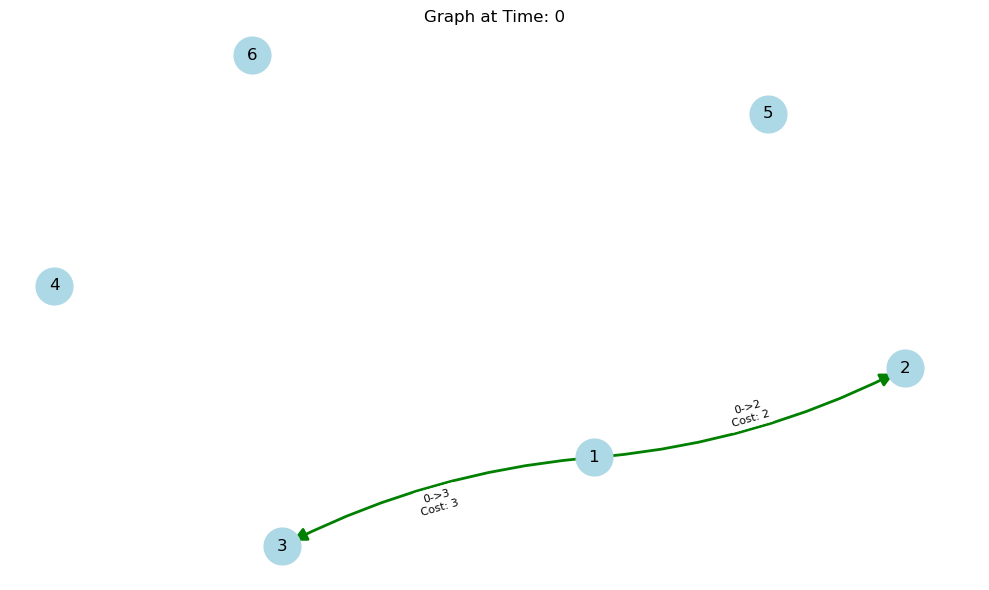

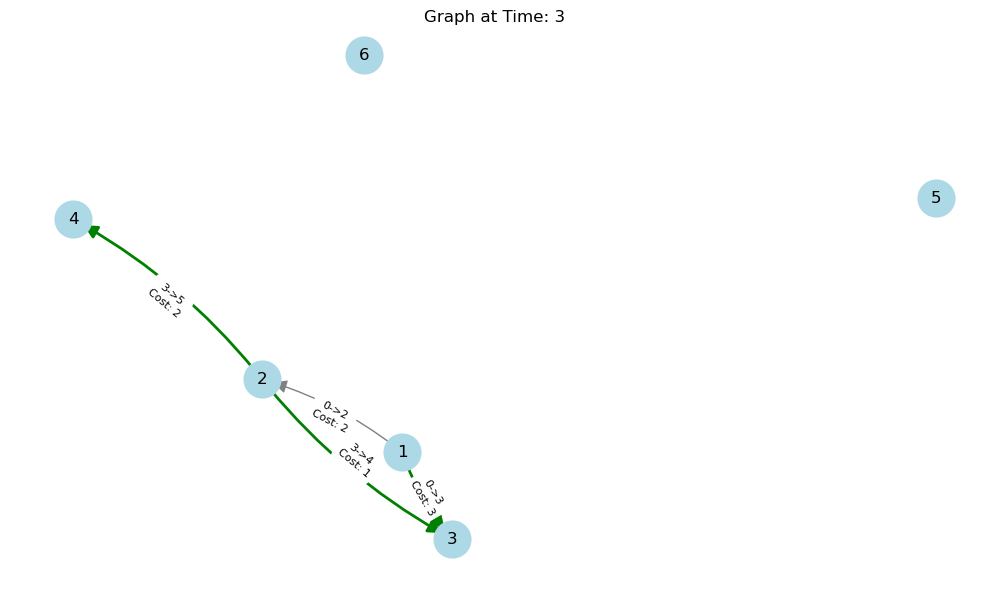

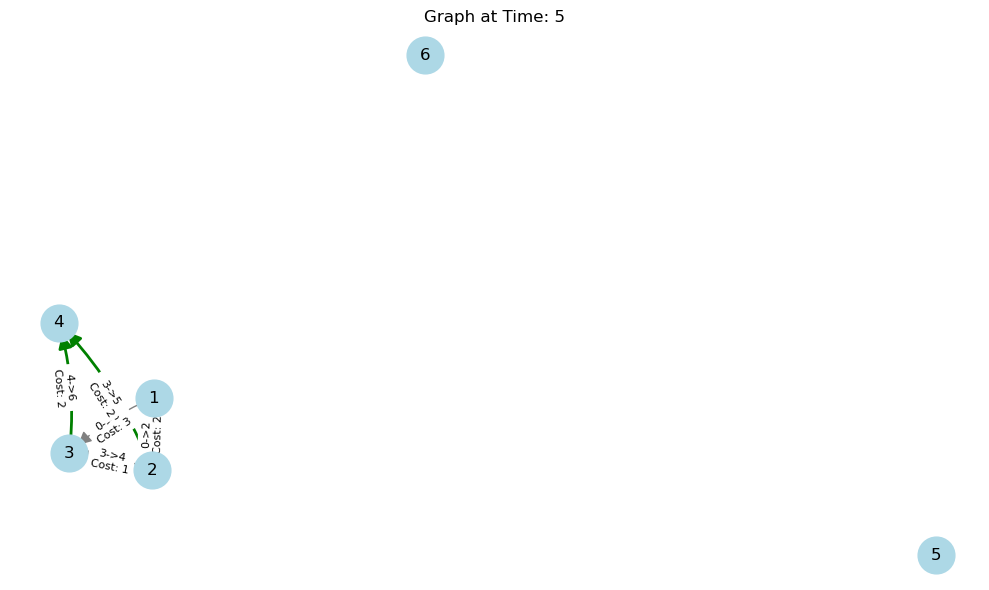

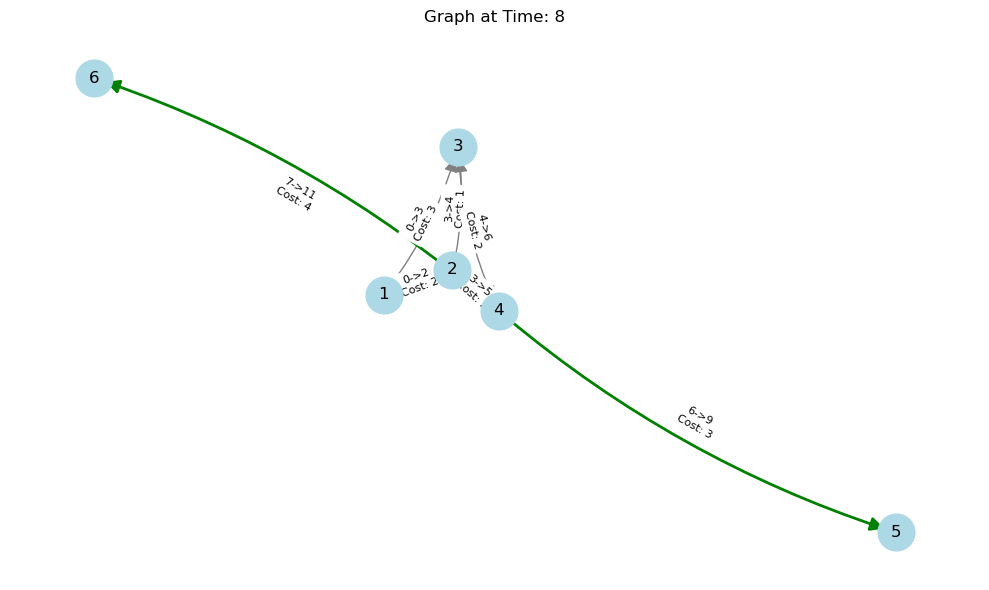

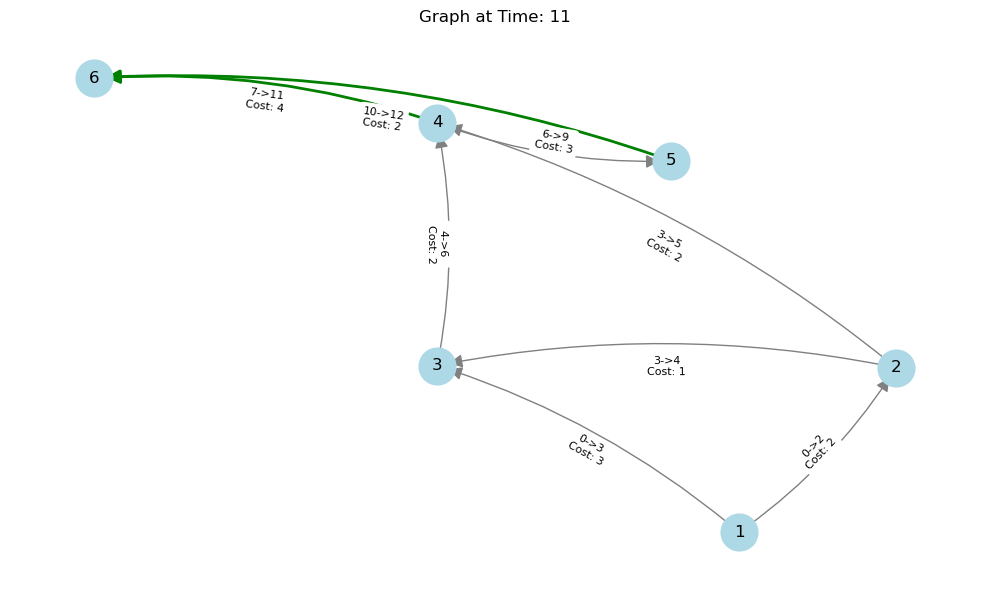

In [5]:
# Function to visualize the graph at a specific time point
def visualize_graph_at_time(graph, time_point):
    G = nx.DiGraph()
    
    # Add all nodes
    for node in graph.nodes:
        G.add_node(node)
    
    # Add edges available at the given time point
    for edge in graph.edges:
        src, dst, length, dep, arr = edge
        if dep <= time_point:
            # Edge is either active or has been used
            if time_point <= arr:
                # Edge is active (departure time <= current time <= arrival time)
                color = 'g'  # green for active
                weight = 2.0
            else:
                # Edge has been used (current time > arrival time)
                color = 'gray'
                weight = 1.0
            
            # Get attributes
            attrs = graph.attributes[edge]
            
            # Add edge with attributes
            G.add_edge(src, dst, length=length, 
                      dep_time=dep, arr_time=arr, 
                      cost=attrs.get('cost', 0),
                      time=attrs.get('time', 0),
                      color=color, weight=weight)
    
    # Visualize
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, seed=42)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    
    # Draw edges with different colors based on their status
    edge_colors = [G.edges[e]['color'] for e in G.edges]
    edge_widths = [G.edges[e]['weight'] for e in G.edges]
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors, 
                           arrowsize=20, connectionstyle='arc3,rad=0.1')
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=12)
    
    # Draw edge labels
    edge_labels = {(u, v): f"{d['dep_time']}->{d['arr_time']}\nCost: {d['cost']}" 
                   for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    plt.title(f"Graph at Time: {time_point}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize the graph at different time points
time_points = [0, 3, 5, 8, 11]
for time in time_points:
    visualize_graph_at_time(graph, time)

## Temporal Paths

A Temporal Path represents a sequence of edges in an Attributed Dynamic Graph that respects temporal constraints. Key properties:

1. Each edge must start from the current node
2. The departure time of each edge must be after the arrival time at the previous node
3. The path accumulates attribute values along the edges

Let's create and analyze some temporal paths:

In [6]:
# Create a temporal path
path = TemporalPath(graph)
path.source = 1  # Start at node 1

# Add edges to the path
try:
    # First edge: 1 -> 2
    path.add_edge((1, 2, 2, 0, 2))
    print("Added edge: 1 -> 2")
    
    # Second edge: 2 -> 4
    path.add_edge((2, 4, 2, 3, 5))
    print("Added edge: 2 -> 4")
    
    # Third edge: 4 -> 5
    path.add_edge((4, 5, 3, 6, 9))
    print("Added edge: 4 -> 5")
    
    # Print path information
    print("\nPath information:")
    print(path)
    print(f"Path length: {path.length}")
    print(f"Path cost: {path.calculate_attribute_value('cost')}")
    print(f"Path time: {path.calculate_attribute_value('time')}")
    print(f"Arrival time: {path.arrival_time}")
    
except ValueError as e:
    print(f"Error: {e}")

Added edge: 1 -> 2
Added edge: 2 -> 4
Added edge: 4 -> 5

Path information:
Path from 1 to 5: (1 -> 2, t=0->2) (2 -> 4, t=3->5) (4 -> 5, t=6->9) 
Path length: 7
Path cost: 7
Path time: 7
Arrival time: 9


### Checking Path Feasibility

A key aspect of temporal paths is checking whether they satisfy a set of constraints. Let's define some constraints and check if our path is feasible:

In [7]:
# Define constraints
constraints = {"cost": 10, "time": 10}
time_interval = (0, 15)

# Check if our path is feasible
is_feasible = path.is_feasible(constraints, time_interval)
print(f"Is path feasible? {is_feasible}")

# Let's try a more restrictive constraint
tight_constraints = {"cost": 5, "time": 5}
is_feasible_tight = path.is_feasible(tight_constraints, time_interval)
print(f"Is path feasible with tighter constraints? {is_feasible_tight}")

# Let's try a more restrictive time interval
tight_time = (0, 8)
is_feasible_time = path.is_feasible(constraints, tight_time)
print(f"Is path feasible with tighter time interval? {is_feasible_time}")

Is path feasible? True
Is path feasible with tighter constraints? False
Is path feasible with tighter time interval? False


### Attributes Embedding

Temporal paths can be represented by their attribute values, normalized by the constraints. This embedding is useful for comparing paths during search:

In [8]:
# Get attribute embedding of the path
attr_embedding = path.get_attribute_embedding(constraints)
print("Attribute embedding:", attr_embedding)

# This embedding represents how close the path is to violating each constraint
# Values close to 1 indicate that the attribute value is close to the constraint limit

Attribute embedding: [0.7 0.7]


## Summary

In this notebook, we've explored the fundamental data structures for the A-MCTS algorithm:

1. **AttributedDynamicGraph**: A graph representation where edges have temporal information and multiple attributes.
2. **TemporalPath**: A sequence of edges that respects temporal constraints and accumulates attribute values.

These structures capture the key aspects of the temporal path finding problem:
- Temporal constraints (edges are only available at specific times)
- Multiple attribute constraints (paths must satisfy constraints on multiple attributes)
- Path length optimization (finding the shortest feasible path)

In the next notebook, we'll explore the A-MCTS algorithm implementation in detail.